In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [23]:
train = pd.read_csv('train.csv')

In [24]:
# OneHotEncode categorical variables
categorical_features = ['publisher_class','lang_code_new', 'type', 'collaboration']
categorical_transformer = OneHotEncoder(drop='first')

# Simple imputer for datetime columns (e.g., fill NaNs with median for simplicity)
def simple_imputer(X):
    return X.fillna(X.median())

datetime_features = ['day', 'month', 'year']
datetime_transformer = FunctionTransformer(simple_imputer, validate=False)

# Assume numerical transformation is scaling (you can replace this with any other transformation if required)
def scale(X):
    std_dev = X.std()
    if (std_dev == 0).all():
        return X - X.mean()
    return (X - X.mean()) / std_dev


numerical_features = ['num_pages', 'ratings_count', 'text_reviews_count']
numerical_transformer = FunctionTransformer(scale, validate=False)

# Assembling the Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('date', datetime_transformer, datetime_features),
        ('num', numerical_transformer, numerical_features),
    ],
    remainder='passthrough'
)



In [25]:
random.seed(42)

X = train.drop('average_rating', axis=1)
y = train['average_rating']

# Split into train and temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split temp into validate and test
X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [72]:

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

# Create different pipelines for different models
pipelines = {
    'xgb': Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(random_state=42))
    ]),
    'rf': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'lasso': Pipeline([
        ('preprocessor', preprocessor),
        ('model', Lasso(random_state=42))
    ])
}


In [73]:
param_grids = {
    'xgb': {
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [4, 6, 8],
        'model__subsample': [0.7, 0.8, 0.9],
        'model__colsample_bytree': [0.7, 0.8, 0.9],
        'model__min_child_weight': [1, 3, 5]
    },
    'rf': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'lasso': {
        'model__alpha': [0.0001, 0.001, 0.01]
    }
}


In [74]:
best_estimators = {}
best_scores = {}

for model_name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, n_jobs=-1,verbose=10)
    grid_search.fit(X_train, y_train)
    
    best_estimators[model_name] = grid_search.best_estimator_
    best_scores[model_name] = grid_search.best_score_
    print(f"{model_name}: {grid_search.best_score_}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits
lasso: 0.08290275281857921


In [75]:
# Evaluate the best model (based on cross-validation score)
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_estimators[best_model_name]

y_pred = best_model.predict(X_validate)
mse = mean_squared_error(y_validate, y_pred)
mae = mean_absolute_error(y_validate, y_pred)

print(f"Best Model: {best_model_name}")
print("MSE:", mse)
print("MAE:", mae)


Best Model: lasso
MSE: 0.10371057226695733
MAE: 0.2196790979248278


In [76]:
# Evaluate on test set
y_test_pred = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Test MSE for {best_model_name}: {mse_test}")
print(f"Test MAE for {best_model_name}: {mae_test}")


Test MSE for lasso: 0.10865071921479616
Test MAE for lasso: 0.217752589930287


Number of transformed features: 28


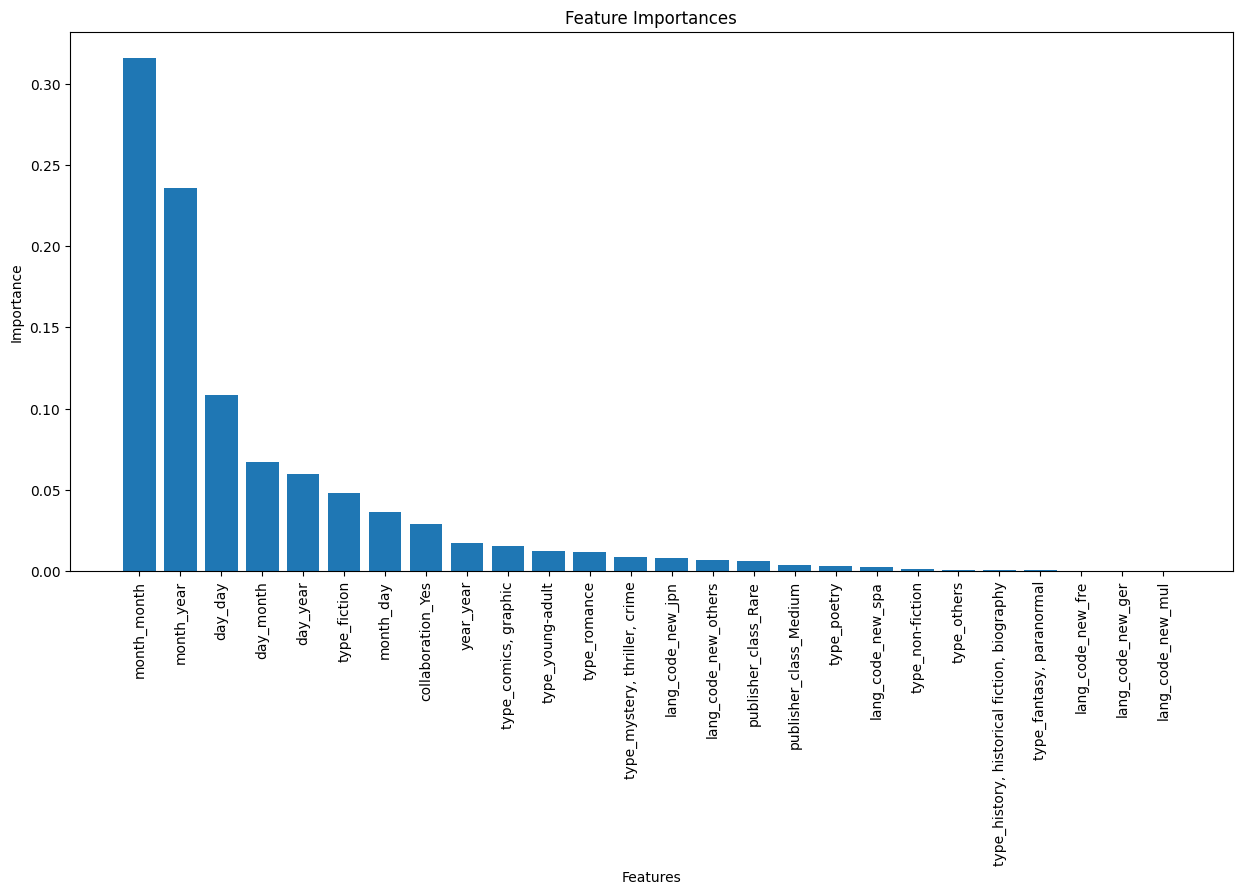

In [66]:
# Initialize an empty list to store the feature names
transformed_feature_names = []

# Loop through transformers of the ColumnTransformer
for name, trans, columns in best_rf.named_steps['preprocessor'].transformers_:
    
    # For transformers that have get_feature_names_out method
    if hasattr(trans, "get_feature_names_out"):
        transformed_feature_names.extend(trans.get_feature_names_out(columns))
        
    # For transformers without get_feature_names_out (e.g., FunctionTransformer)
    elif name == 'date':  # assuming the transformer for dates is named 'date'
        # Here, you might need to manually specify the transformed feature names for the 'date' transformer
        # For example, if your FunctionTransformer extracts year, month, and day:
        date_features = [feature for col in columns for feature in [f"{col}_year", f"{col}_month", f"{col}_day"]]
        transformed_feature_names.extend(date_features)
        
    else:
        # If there are other transformers, handle them similarly to the 'date' transformer above
        pass

print("Number of transformed features:", len(transformed_feature_names))

transformed_feature_names = np.array(transformed_feature_names)  # Convert to numpy array

sorted_idx = importances.argsort()[::-1]
plt.figure(figsize=(15, 7))
plt.bar(transformed_feature_names[sorted_idx], importances[sorted_idx])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()


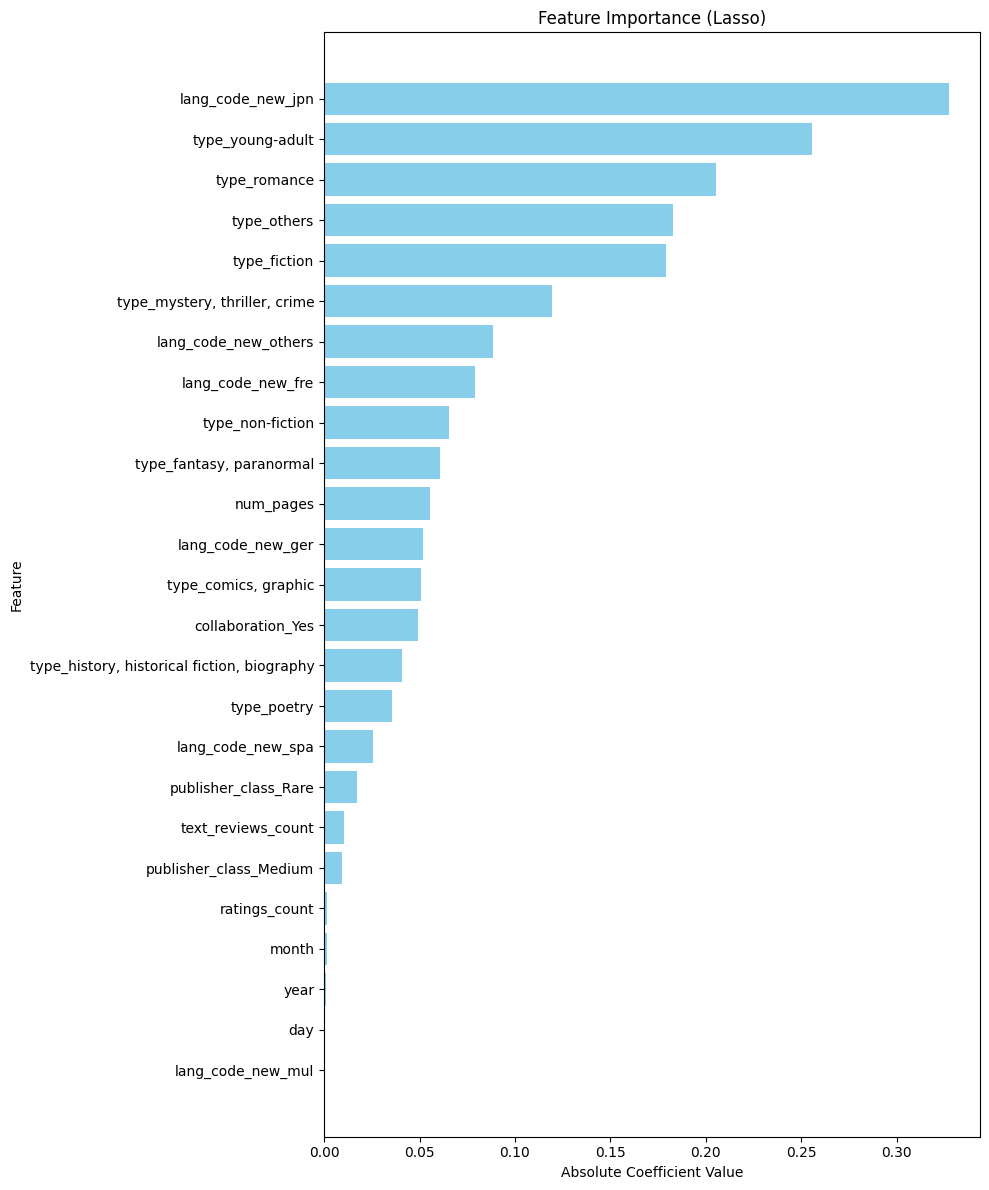

In [77]:
import matplotlib.pyplot as plt

if best_model_name == 'lasso':
    # Get coefficients from the Lasso model
    coefficients = best_model.named_steps['model'].coef_

    # Exclude the extra coefficient for now
    coefficients = coefficients[:-1]

    # Extract transformed feature names from the pipeline's preprocessor
    cat_features = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=categorical_features)
    date_features = datetime_features  # they are passed through without any change in name
    num_features = numerical_features  # they are passed through without any change in name
    features = list(cat_features) + list(date_features) + list(num_features)

    # Map coefficients to feature names
    feature_coefficients = pd.DataFrame({'feature': features, 'coefficient': coefficients, 'absolute_coefficient': abs(coefficients)}).sort_values(by='absolute_coefficient', ascending=True)

    # Plotting feature importance
    plt.figure(figsize=(10, 12))
    plt.barh(feature_coefficients['feature'], feature_coefficients['absolute_coefficient'], color='skyblue')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Feature Importance (Lasso)')
    plt.tight_layout()
    plt.show()

else:
    print(f"{best_model_name} does not support feature importances.")


In [78]:
# Save the best model
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)